# Philosophy of bias
What is bias? 
There are many ways it could be defined, but I'm going to use a mathematical definition here: 
$observation = bias \star reality$

Where $observation$ is some quantity that is measured, $reality$ refers to the actual thing that is being studied, and $\star$ is some operation, like addition or convolution. Bias is, by my definition, the signal that is combined with reality in order to produce the observation.

As a simple example of bias, consider the case where you forget to zero out a balance before weighing out a chemical. In this case, 
$measured = offset + weight$

A bias could be random, like a noisy detector. It could be very complex, like if you're trying to study the role of race in income inequality:
$observed cause = bias \star real cause$
where the bias is based on your upbringing, economic assumptions, and any number of other factors. 

In a perfect world, we would like to measure reality. In this case, $bias \star$ would be an identity operator, so that 
$observation = reality$
and we spend a great deal of work making this happen. For example, we use clean pipette tips instead of re-using them. We tare a balance before weighing something. 

An alternative strategy is to characterize the bias and the biasing operator $\star$, so that we can reverse engineer what the reality was:
$reality = observation \star^{-1} bias$

And this is what we do when we perform a control experiment. 
In this notebook, I'm going to discuss how we can use neural networks to control for biases in experimental data. And in order to do that, I'm going to start with...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# RF Modulation
How do you communicate information over a radio link? Let's say you want to communicate this string of bits:

In [2]:
NUM_SYMBOLS = 4000
bit_pattern = [random.choice([0,1,2,3]) for x in range(NUM_SYMBOLS)]
SIGNAL_DURATION=1
SAMPLING_RATE = 1000000
NUM_SAMPLES = SIGNAL_DURATION*SAMPLING_RATE

You could send this bit pattern over the air by applying 0 or 5 volts to an antenna at some known time for each bit.

In [3]:
import math
def binaryToVoltage(message, numSamples):
    voltages = np.zeros((numSamples))
    stepsPerSymbol = numSamples / len(message)
    for i, symbol in enumerate(message):
        startPos = math.ceil(i * stepsPerSymbol)
        endPos = min(numSamples, math.ceil(startPos + stepsPerSymbol))
        voltages[startPos:endPos] = symbol
    return voltages

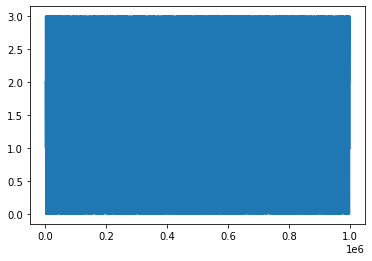

In [4]:
plt.plot(binaryToVoltage(bit_pattern, NUM_SAMPLES))


From that, we could reconstruct the original data. But that's not how the real world works. For one thing, the rest of the world is also transmitting.

In [5]:
import random
def randomSignal(length):
    return [random.choice([0,1,2,3]) for x in range(length)]
background_signals = [binaryToVoltage(randomSignal(NUM_SYMBOLS), SAMPLING_RATE) for x in range(20)]
real_signal = binaryToVoltage(bit_pattern, SAMPLING_RATE)
all_signals = [real_signal] + background_signals
background_signals = np.array(background_signals)
all_signals = np.array(all_signals)

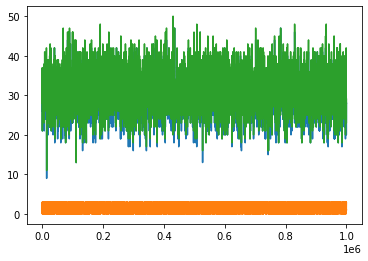

In [6]:
plt.plot(background_signals.sum(axis=0))
plt.plot(real_signal)
plt.plot(all_signals.sum(axis=0))

In [7]:
print(real_signal.shape)

(1000000,)


In [8]:
#How could we go about extracting our data again? It's totally lost with everyone else's transmission. 

In [9]:
#The answer is to modulate the signal. 

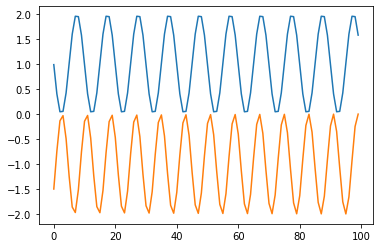

In [10]:
#We need 21 carrier signals. 
freq_start = 100000 #100 KHz
freq_band = 1234 # 1 KHz spacing
freq_stop = freq_start + 21 * freq_band
carrierFrequencies = np.arange(freq_start, freq_stop, freq_band)
random_frac = 0.
def getTimes(frequency):
    randomPart = np.random.random((NUM_SAMPLES,)) + 0.5
    linearPart = np.ones((NUM_SAMPLES,))
    joined = randomPart * random_frac + linearPart * (1-random_frac)
    scaled = joined * SIGNAL_DURATION / SAMPLING_RATE
    phaseOffset = np.random.random((1,))*10
    frequencyScaled = np.cumsum(scaled) * frequency * 2 * math.pi
    
    return frequencyScaled + phaseOffset
carrierTimes = np.array([getTimes(x) for x in carrierFrequencies])
#Add a bit of uncertainty to the times; this adds phase noise to the signal.
#carrierTimes += phaseNoise
carriers = np.cos(carrierTimes)
plt.plot(carriers[0][:100] + 1)
plt.plot(carriers[-1][:100] - 1)

In [11]:
#So now we have these carrier frequencies. We can add them all together to get what would happen if
#you transmitted all of them at once:

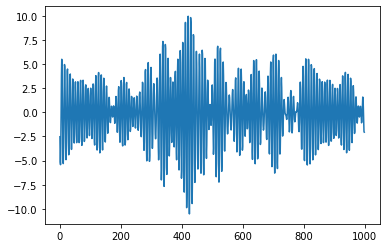

In [12]:
plt.plot(np.sum(carriers, axis=0)[:1000])

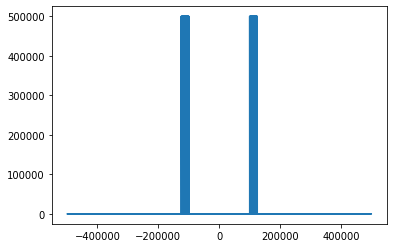

In [13]:
cfft = np.fft.fft(np.sum(carriers, axis=0))
freqs = np.fft.fftfreq(carriers.shape[1], SIGNAL_DURATION/SAMPLING_RATE)
plt.plot(freqs, np.abs(cfft))

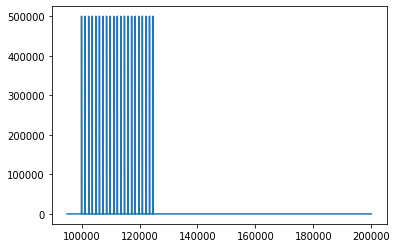

In [14]:
freqStart = 95000
freqEnd = 200000
gofreqs = np.logical_and(freqs > freqStart, freqs < freqEnd)

plt.plot(freqs[gofreqs], np.abs(cfft)[gofreqs])

In [15]:
from scipy import signal

In [16]:
f, t, sxx = signal.spectrogram(np.sum(carriers, axis=0), nperseg=SAMPLING_RATE//100)

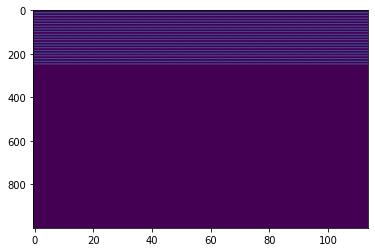

In [17]:
plt.imshow(sxx[1000:2000], aspect='auto')

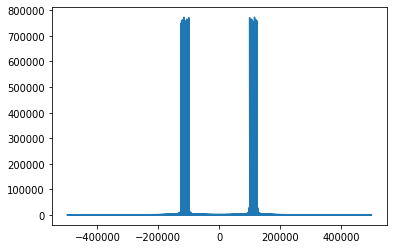

In [18]:
transDat = carriers * all_signals
tdfft = np.fft.fft(np.sum(transDat, axis=0))
tdfreqs = np.fft.fftfreq(transDat.shape[1], 1/SAMPLING_RATE)
plt.plot(tdfreqs, np.abs(tdfft))

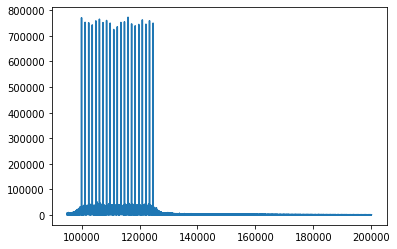

In [19]:
freqStart = 95000
freqEnd = 200000
gofreqs = np.logical_and(tdfreqs > freqStart, tdfreqs < freqEnd)

plt.plot(tdfreqs[gofreqs], np.abs(tdfft)[gofreqs])

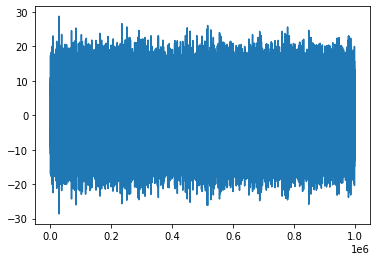

In [20]:
plt.plot(np.sum(transDat, axis=0))

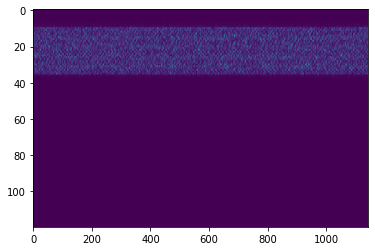

In [21]:
bitRate = 1000
f, t, sxx = signal.spectrogram(np.sum(transDat, axis=0), nperseg=SAMPLING_RATE//bitRate)
plt.imshow(sxx[90000//bitRate:210000//bitRate], aspect='auto')

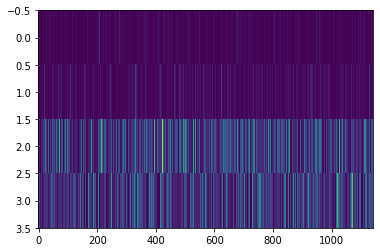

In [22]:
recDats = sxx[99000//bitRate-1:101000//bitRate+1]
plt.imshow(recDats, aspect='auto', interpolation='nearest')

(0.0, 2.5)

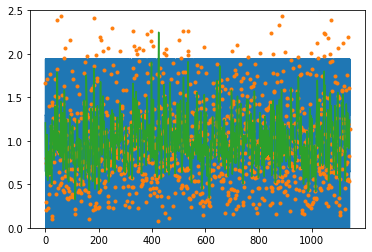

In [23]:

recovered = np.sum(recDats, axis=0)
plt.plot(np.linspace(0, recDats.shape[1], num = real_signal.shape[0]), real_signal / np.mean(real_signal))
from scipy import ndimage
filteredRecovered = ndimage.gaussian_filter(recovered, 1)
plt.plot(recovered / np.mean(recovered), '.')
plt.plot(filteredRecovered / np.mean(filteredRecovered))
plt.ylim(0,2.5)
#plt.xlim(0,100)

(1142,)


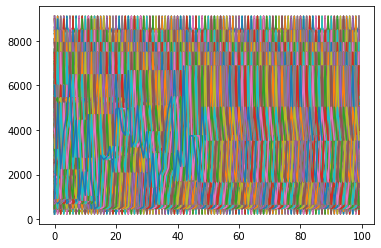

In [24]:
#Let's build up an eye diagram.
print(filteredRecovered.shape)
cross_points = np.linspace(0, filteredRecovered.shape[0], num=NUM_SYMBOLS+1)
eyes = []
width = 50
for i in cross_points:
    eyes.append( recovered[math.floor(i-width):math.floor(i+width)])
for e in eyes:
    plt.plot(e, '-')

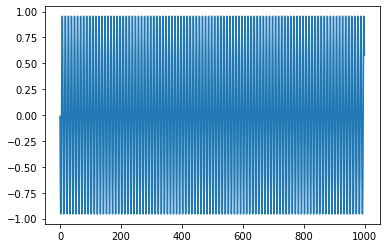

In [25]:
plt.plot(carriers[0][:1000])

In [26]:
trans = np.sum(transDat, axis=0)
cd = trans * carriers[0]

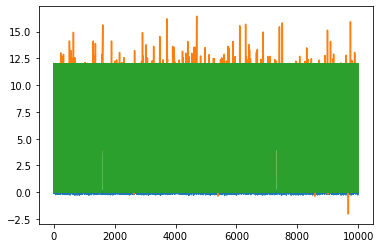

In [27]:
plt.plot(cd[::100])
cdf = ndimage.gaussian_filter1d(cd, 400)
plt.plot(cdf[::100]*10)
plt.plot(real_signal[::100]*4)

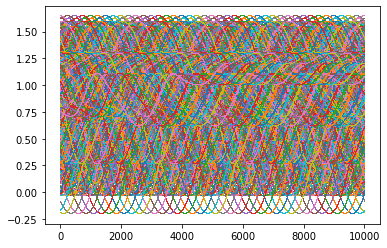

In [28]:
cross_points = np.linspace(0, NUM_SAMPLES, num=NUM_SYMBOLS+1)
eyes = []
width = 5000
for i in cross_points[2:-2]:
    eyes.append( cdf[math.floor(i-width):math.floor(i+width)])
for e in eyes:
    plt.plot(e, ',')

In [29]:
def frequencyModulate(carrierFreq, modulation, bandwidth):
    carrierBaseTimes = np.ones((NUM_SAMPLES,)) / SAMPLING_RATE * carrierFreq
    #Normalize the modulation
    modulation = modulation - np.min(modulation)
    modulation /= np.max(modulation)
    modulation -= 1/2
    modulation *= 2
    #Modulation goes from -1 to 1.
    #Now scale it to go to its bandwidth.
    modulation /= SAMPLING_RATE
    modulation *= bandwidth
    
    carrierModTimes = carrierBaseTimes + modulation
    carrierTimes = np.cumsum(carrierModTimes) * 2 * math.pi
    return np.cos(carrierTimes), carrierBaseTimes, carrierModTimes, carrierTimes

In [30]:
fmbw = 5000
fm,cb, cm, ct = frequencyModulate(50000, real_signal, fmbw)
carrier, _,_,_ = frequencyModulate(40000, real_signal, 0)

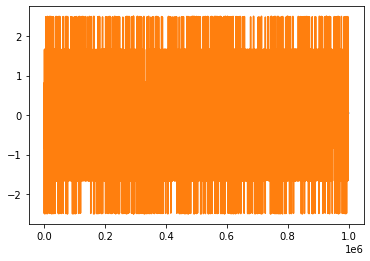

In [31]:

plt.plot(cb)
plt.plot((ct - ndimage.gaussian_filter1d(ct,100))[1000:-1000])
#plt.plot(fm*max(ct))


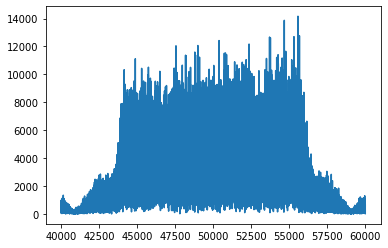

In [32]:
fmfreqs = np.fft.fftfreq(fm.shape[0], 1/SAMPLING_RATE)
fmfft = np.fft.fft(fm)
freqStart = 50000-2*fmbw
freqEnd = 50000+2*fmbw
gofreqs = np.logical_and(fmfreqs > freqStart, fmfreqs < freqEnd)

plt.plot(fmfreqs[gofreqs], np.abs(fmfft)[gofreqs])

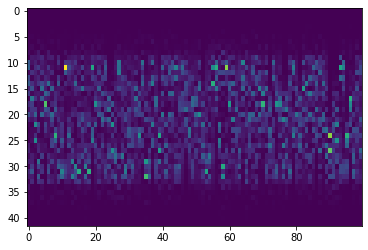

In [33]:
bitRate = 500
f, t, sxx = signal.spectrogram(fm, nperseg=SAMPLING_RATE//bitRate)
recDats = sxx[40000//bitRate-1:60000//bitRate+1]
plt.imshow(recDats[:,:100], aspect='auto', interpolation='nearest')

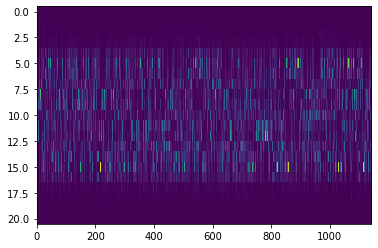

In [34]:
bitRate = 1000
ifreq = carrier * fm
f, t, sxx = signal.spectrogram(ifreq, nperseg=SAMPLING_RATE//bitRate)
recDats = sxx[1000//bitRate-1:20000//bitRate+1]
plt.imshow(recDats, aspect='auto', interpolation='nearest')

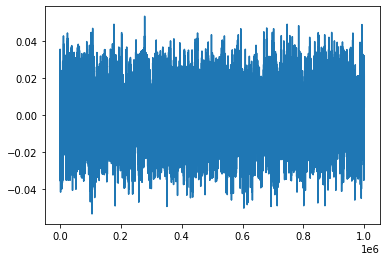

In [35]:
plt.plot(ndimage.uniform_filter1d(ifreq,1000))

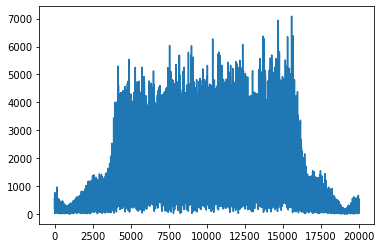

In [36]:
fmfreqs = np.fft.fftfreq(ifreq.shape[0], 1/SAMPLING_RATE)
fmfft = np.fft.fft(ifreq)
freqStart = 0
freqEnd = 20000
gofreqs = np.logical_and(fmfreqs > freqStart, fmfreqs < freqEnd)

plt.plot(fmfreqs[gofreqs], np.abs(fmfft)[gofreqs])

In [37]:
sos = signal.bessel(2, [44000,46000], btype='bandpass', fs=SAMPLING_RATE, output='sos')
bw=fmbw/2
bands = [[x-bw,x+bw] for x in np.linspace(40000, 60000, 4)]
print(bands)
filters = [signal.bessel(1, x, btype='bandpass', fs=SAMPLING_RATE, output='sos') for x in bands]

filts = [signal.sosfilt(f, fm) for f in filters]

[[37500.0, 42500.0], [44166.666666666664, 49166.666666666664], [50833.333333333336, 55833.333333333336], [57500.0, 62500.0]]


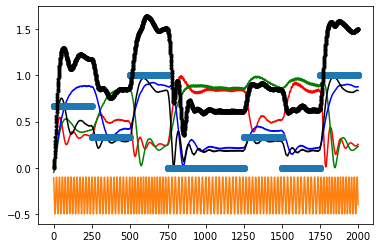

In [38]:
reconstructed = np.zeros(filts[0].shape)
colors = 'rgbk'
plotTo = 2000
for i, filt in enumerate(filts):
    filtfilt = ndimage.gaussian_filter1d(np.abs(filt),5)
    filtfilt -= np.min(filtfilt[1000:-1000])
    filtfilt /= np.max(filtfilt[1000:-1000])
    plt.plot(filtfilt[:plotTo], colors[i])

    reconstructed += i * filtfilt
plt.plot(real_signal[:plotTo]/3, 'o')
plt.plot(reconstructed[:plotTo]/3, 'k.')
plt.plot(fm[:plotTo]/5-0.3)

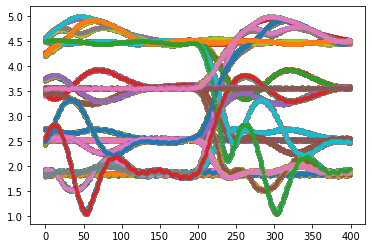

In [43]:
cross_points = np.linspace(0, NUM_SAMPLES, num=NUM_SYMBOLS+1)
eyes = []
width = 200
for i in cross_points[2:-2]:
    eyes.append( reconstructed[math.floor(i-width):math.floor(i+width)])
for e in eyes:
    plt.plot(e, '.')

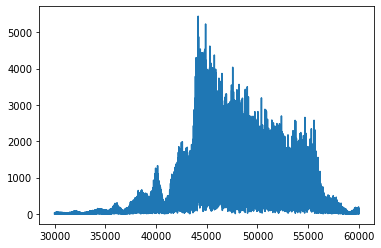

In [40]:
fmfreqs = np.fft.fftfreq(filts[0].shape[0], 1/SAMPLING_RATE)
fmfft = np.fft.fft(filts[0])
freqStart = 30000
freqEnd = 60000
gofreqs = np.logical_and(fmfreqs > freqStart, fmfreqs < freqEnd)

plt.plot(fmfreqs[gofreqs], np.abs(fmfft)[gofreqs])

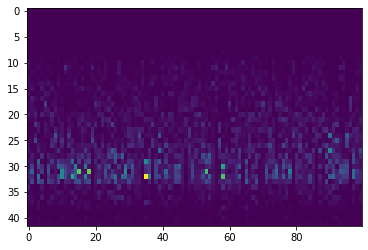

In [41]:
bitRate = 500
f, t, sxx = signal.spectrogram(filt, nperseg=SAMPLING_RATE//bitRate)
recDats = sxx[40000//bitRate-1:60000//bitRate+1]
plt.imshow(recDats[:,:100], aspect='auto', interpolation='nearest')